In [1]:
from skimage import data, measure
import skimage as sk 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import normalize, minmax_scale
from skimage.util import random_noise
from skimage.filters import gaussian
from skimage import measure
import tensorflow as tf
import keras
from keras import layers

import generator
from explainabilityModels import make_gradcam_heatmap as GradCam

In [74]:
from tensorflow.keras.utils import image_dataset_from_directory
#load the data from the test data folder
model = tf.keras.models.load_model("models/leukaemia/model")
test_dir = "leukaemia_images"
test_dataset = image_dataset_from_directory(
                test_dir,
                labels = None,
                seed = 42,
                image_size = (224,224),
                batch_size = 64,
                shuffle = False
                )

x = test_dataset.unbatch()
imgs = np.array(list(x))
imgs = imgs/255.0

Found 49 files belonging to 1 classes.


Text(0.5, 1.0, 'Parasitised cell')

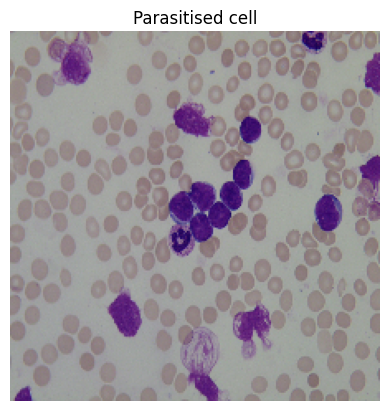

In [75]:
plt.imshow(imgs[0])
plt.axis('off')
plt.title('Parasitised cell')

In [293]:
import ipywidgets as widgets

method_picker = widgets.Dropdown(
    options=[('Grad-CAM', 0), ('Grad-CAM++', 1), ('ScoreCAM', 2), ('LayerCAM', 3)],
    value=0,
    description='Method:',
)

#pick what you want to see
display(method_picker)



Dropdown(description='Method:', options=(('Grad-CAM', 0), ('Grad-CAM++', 1), ('ScoreCAM', 2), ('LayerCAM', 3))…

In [312]:
from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.layercam import Layercam
from tf_keras_vis.scorecam import Scorecam
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils.scores import CategoricalScore
model = tf.keras.models.load_model("models/leukaemia/model")
#model.layers[-1].activation = None
cat = CategoricalScore(1)
mod = ReplaceToLinear()
if method_picker.value == 0:
    method = Gradcam(model, model_modifier = mod, clone=True)
elif method_picker.value == 1:
    method = GradcamPlusPlus(model, model_modifier = mod, clone = True)

elif method_picker.value == 2:
    method = Scorecam(model)

elif method_picker.value == 3:
    method = Layercam(model,model_modifier = mod, clone=True)


method

In [313]:
#make gradcam heatmap for every image and normalise
heatmaps = np.zeros([imgs.shape[0], imgs.shape[1], imgs.shape[2]])

for img in range(imgs.shape[0]):
    heatmaps[img, :, :] = method(cat, imgs[img, :, :, :]).squeeze()
    #heatmaps[img, :, :] = GradCam(imgs[img, :, :, :], model, pred_index=0)
    #heatmaps[img, :, :] /= 255


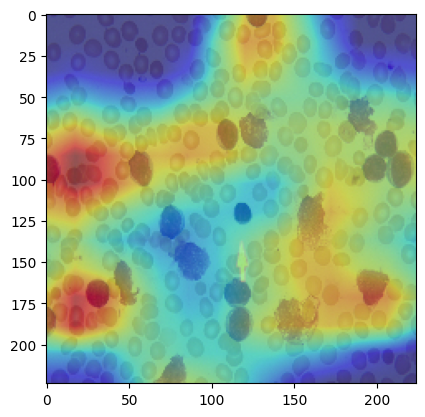

In [314]:
plt.imshow(imgs[1])
plt.imshow(heatmaps[1], alpha = 0.5, cmap = 'jet')

In [315]:
from sklearn.datasets import make_blobs
from sklearn import mixture
from skimage.morphology import opening, disk, square, erosion
from tqdm import tqdm
#perform GMM segmentation on all images. This typically takes a while, which is why we're saving the segmentations. Only run this once and then skip it in further runs
segmentations = np.zeros_like(heatmaps)
for img in tqdm(range(imgs.shape[0])):
    v_I = np.reshape(imgs[img, :,:,:],(imgs[img, :,:,:].shape[0]*imgs[img,:,:,:].shape[1],imgs[img,:,:,:].shape[2]))
    gmm_win = mixture.GaussianMixture(n_components=3,covariance_type='full').fit(v_I)

    v_I_gmm = gmm_win.predict(v_I)
    I_gmm = np.reshape(v_I_gmm,[imgs[img,:,:,:].shape[0],imgs[img,:,:,:].shape[1]])
    #opened = erosion(I_gmm, square(2))
    segmentations[img,:,:] = I_gmm

100%|██████████| 49/49 [00:15<00:00,  3.22it/s]


(-0.5, 223.5, 223.5, -0.5)

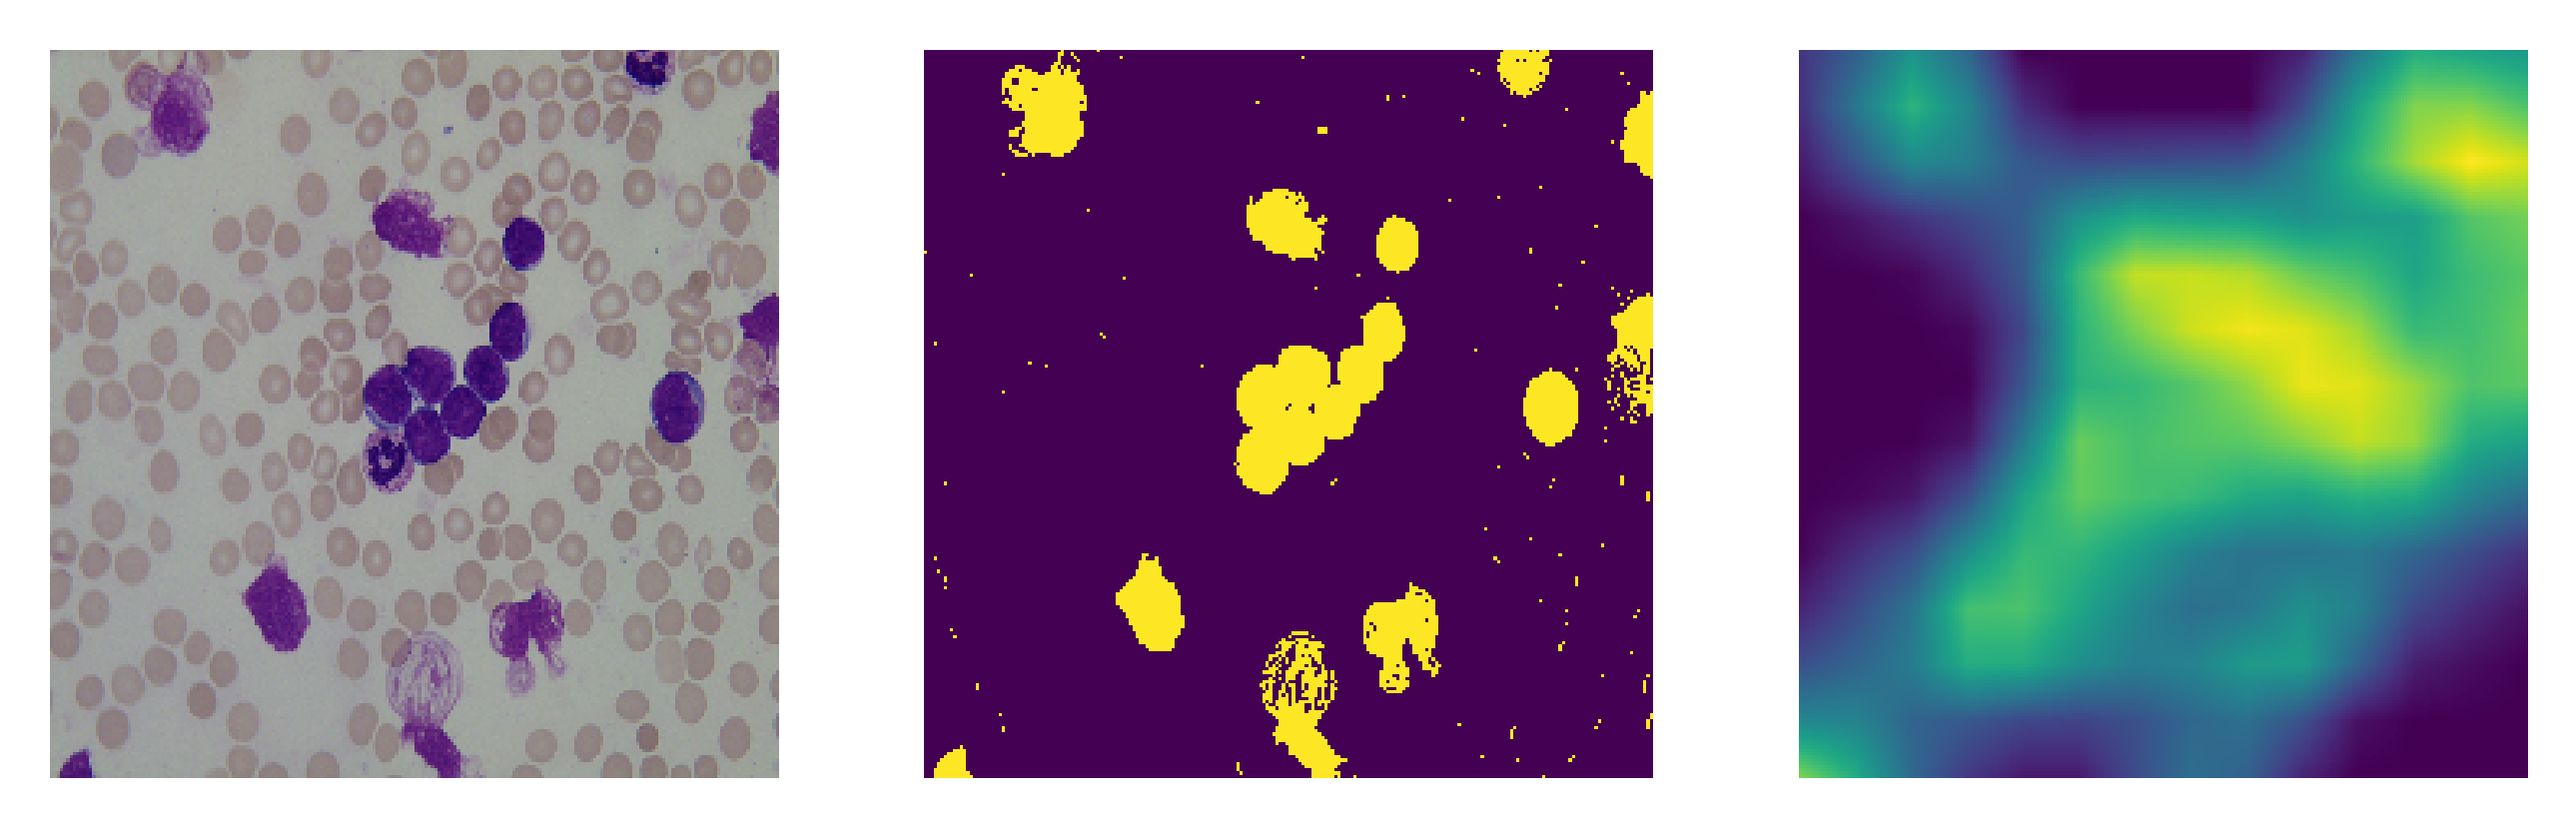

In [316]:
#display an example image with segmentation and heatmap
idx = 0
fig,ax = plt.subplots(1,3)
fig.set_dpi(500)
ax[0].imshow(imgs[idx])
ax[0].axis('off')
ax[1].imshow(segmentations[idx] == np.argmin(np.unique(segmentations[idx], return_counts=True)[1]))
ax[1].axis('off')
ax[2].imshow(heatmaps[idx])
ax[2].axis('off')


In [317]:
import skimage.morphology as morph
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from scipy import ndimage as ndi
final = np.zeros_like(segmentations)
for idx in range(segmentations.shape[0]):
    x = segmentations[idx] == np.argmin(np.unique(segmentations[idx], return_counts=True)[1])
    x = morph.remove_small_objects(x)
    distance = ndi.distance_transform_edt(x)
    coords = peak_local_max(distance, footprint=np.ones((3, 3)), labels=x)
    mask = np.zeros(distance.shape, dtype=bool)
    mask[tuple(coords.T)] = True
    markers, _ = ndi.label(mask)
    labels = watershed(-distance, markers, mask=x)
    final[idx] = labels
final = final.astype('uint8')

In [318]:
#find number of blobs in all images
num_blobs_array = []
for img in range(imgs.shape[0]):
    num_blobs_array.append(np.unique(final[img]).shape[0] - 1)

num_blobs = sum(num_blobs_array)
num_blobs

3592

In [319]:
from skimage.measure import label,regionprops_table
from skimage import data, measure
import pandas as pd
from scipy.spatial.distance import pdist,squareform
blob_neighbours = []
blob_centre_distances = []
centre = imgs.shape[1]//2

for img in range(imgs.shape[0]):
  props = measure.regionprops_table(final[img],properties=['centroid'])

  df = pd.DataFrame(props)
  CX = df['centroid-0'].astype('int').values
  CY = df['centroid-1'].astype('int').values
  C = np.vstack([CX,CY]).T
  for blob in range(C.shape[0]):
    centre_dist = np.sqrt((C[blob,0]-centre)**2+(C[blob,1]-centre)**2)
    blob_centre_distances.append(centre_dist)

  rad = 10
  D = pdist(C)
  DS = squareform(D)
  for kpoint in range(C.shape[0]):
    blob_neighbours.append(np.where(DS[kpoint,:] < rad)[0].shape[0]-1)

blob_neighbours = np.asarray(blob_neighbours)
blob_centre_distances = np.asarray(blob_centre_distances)

In [302]:
num_blobs/imgs.shape[0]

73.3061224489796

In [320]:
#generate interpretability scores for each blob; score is the sum of intensities of heatmap in the region
#plus get the highest score for every image
scores = np.zeros(num_blobs)
green_vals = np.zeros(num_blobs)
red_vals = np.zeros(num_blobs)
blue_vals = np.zeros(num_blobs)
i = 0
highscores = []
for img in range(imgs.shape[0]):
    img_highscore = 0
    for region in np.unique(final[img]):   
        if region != 0:
            x = np.copy(final[img])
            x[x != region] = 0
            x[x == region] = 1
            img_score = heatmaps[img] * x
            img_green_val = imgs[img, :, :, 1] * x #extract the RGB values from the image; in this case green
            img_red_val = imgs[img, :, :, 0] * x
            img_blue_val = imgs[img, :, :, 2] * x

            scores[i] = np.mean(img_score[img_score!=0])

            green_vals[i] = np.mean(img_green_val[img_green_val!=0])
            red_vals[i] = np.mean(img_red_val[img_red_val!=0])
            blue_vals[i] = np.mean(img_blue_val[img_blue_val!=0])
            if scores[i] > img_highscore:
                img_highscore = scores[i]
            i += 1
    highscores.append(img_highscore)
        

C:\Users\William\AppData\Roaming\Python\Python39\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\William\AppData\Roaming\Python\Python39\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [321]:
scores = np.nan_to_num(scores, nan=0)

In [322]:
highscores = np.asarray(highscores)
ind = np.where(np.in1d(scores, highscores))[0]
ind.shape

(49,)

In [323]:
from skimage.measure import regionprops_table
from tqdm import tqdm
blob_areas = []
blob_eccentricities = []
blob_eq_diameter = []
blob_bboxs = []
blob_major_axes = []
blob_minor_axes = []
blob_extents = []
blob_solidities = []

for img in tqdm(range(imgs.shape[0])):
    areas = pd.DataFrame(regionprops_table(final[img], properties=['area'])).to_numpy().squeeze()
    eccentricities = pd.DataFrame(measure.regionprops_table(final[img], properties=['eccentricity'])).to_numpy().squeeze()
    eq_diameter = pd.DataFrame(measure.regionprops_table(final[img], properties=['equivalent_diameter_area'])).to_numpy().squeeze()
    bbox = pd.DataFrame(measure.regionprops_table(final[img], properties=['area_bbox'])).to_numpy().squeeze()
    major_axis = pd.DataFrame(measure.regionprops_table(final[img], properties=['axis_major_length'])).to_numpy().squeeze()
    minor_axis = pd.DataFrame(measure.regionprops_table(final[img], properties=['axis_minor_length'])).to_numpy().squeeze()
    extent = pd.DataFrame(measure.regionprops_table(final[img], properties=['extent'])).to_numpy().squeeze()
    solidity = pd.DataFrame(measure.regionprops_table(final[img], properties=['solidity'])).to_numpy().squeeze()
    # some images have only one region, which is why the tolist() method doesn't work
    # we check for a single element and append instead of calling tolist()
    if areas.shape == ():
        blob_areas.append(areas)
    else:
        blob_areas += areas.tolist()

    if eccentricities.shape == ():
        blob_eccentricities.append(eccentricities)
    else:
        blob_eccentricities += eccentricities.tolist()

    if eq_diameter.shape == ():
        blob_eq_diameter.append(eq_diameter)
    else:
        blob_eq_diameter += eq_diameter.tolist()

    if bbox.shape == ():
        blob_bboxs.append(bbox)
    else:
        blob_bboxs += bbox.tolist()

    if major_axis.shape == ():
        blob_major_axes.append(major_axis)
    else:
        blob_major_axes += major_axis.tolist()

    if minor_axis.shape == ():
        blob_minor_axes.append(minor_axis)
    else:
        blob_minor_axes += minor_axis.tolist()

    if extent.shape == ():
        blob_extents.append(extent)
    else:   
        blob_extents += extent.tolist()

    if solidity.shape == ():
        blob_solidities.append(solidity)
    else:
        blob_solidities += solidity.tolist()

blob_areas = np.asarray(blob_areas)
blob_eccentricities = np.asarray(blob_eccentricities)
blob_eq_diameter = np.asarray(blob_eq_diameter)
blob_bboxs = np.asarray(blob_bboxs)
blob_major_axes = np.asarray(blob_major_axes)
blob_minor_axes = np.asarray(blob_minor_axes)
blob_extents = np.asarray(blob_extents)
blob_solidities = np.asarray(blob_solidities)
blob_areas.shape


100%|██████████| 49/49 [00:03<00:00, 12.25it/s]


(3592,)

In [324]:
#prepare data for training
from sklearn.model_selection import train_test_split
X = np.vstack((green_vals, red_vals, blue_vals, blob_areas, blob_eccentricities, blob_eq_diameter, blob_bboxs, blob_extents, blob_major_axes, blob_minor_axes, blob_solidities, blob_neighbours, blob_centre_distances))
# X = np.vstack((green_vals, blob_major_axes))

X = np.transpose(X)
y = scores

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)





In [325]:
#build regression tree
from sklearn.tree import DecisionTreeRegressor
regressor = DecisionTreeRegressor(max_depth=2)
regressor = regressor.fit(X_train, y_train)

In [326]:
score = regressor.score(X_test, y_test)
score

0.22900859556381392

In [327]:
from sklearn.ensemble import RandomForestRegressor

feature_names = ['Green_val', 'Red_val', 'Blue_val', 'Area', 'Eccentricity', 'Equivalent Diameter', 'Bounding Box Area', 'Extent', 'Major Axis', 'Major Axis', 'Solidity', 'Number of Neighbours', 'Distance from centre']
forest = RandomForestRegressor(random_state=42)
forest.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [328]:
forest.score(X_test, y_test)

0.47685741474119214

In [291]:
from sklearn.inspection import permutation_importance

result = permutation_importance(forest, X_test, y_test, n_repeats = 10, random_state=42, n_jobs=2)

forest_importances = pd.Series(result.importances_mean, index=feature_names)

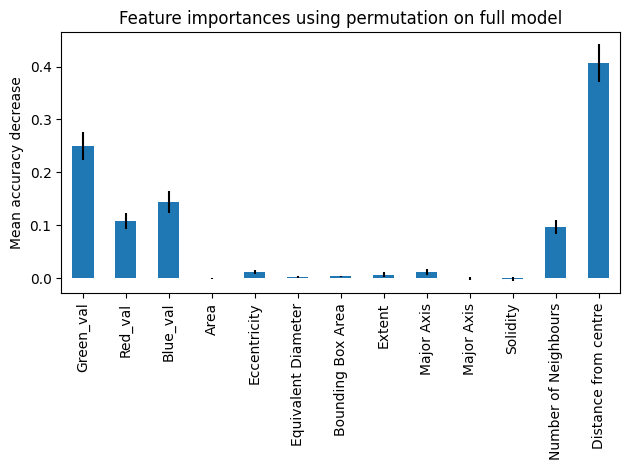

In [292]:
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

In [266]:
#repeat the decision tree with only the most important features
X = np.vstack((red_vals, blob_centre_distances))

X = np.transpose(X)
y = scores

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)




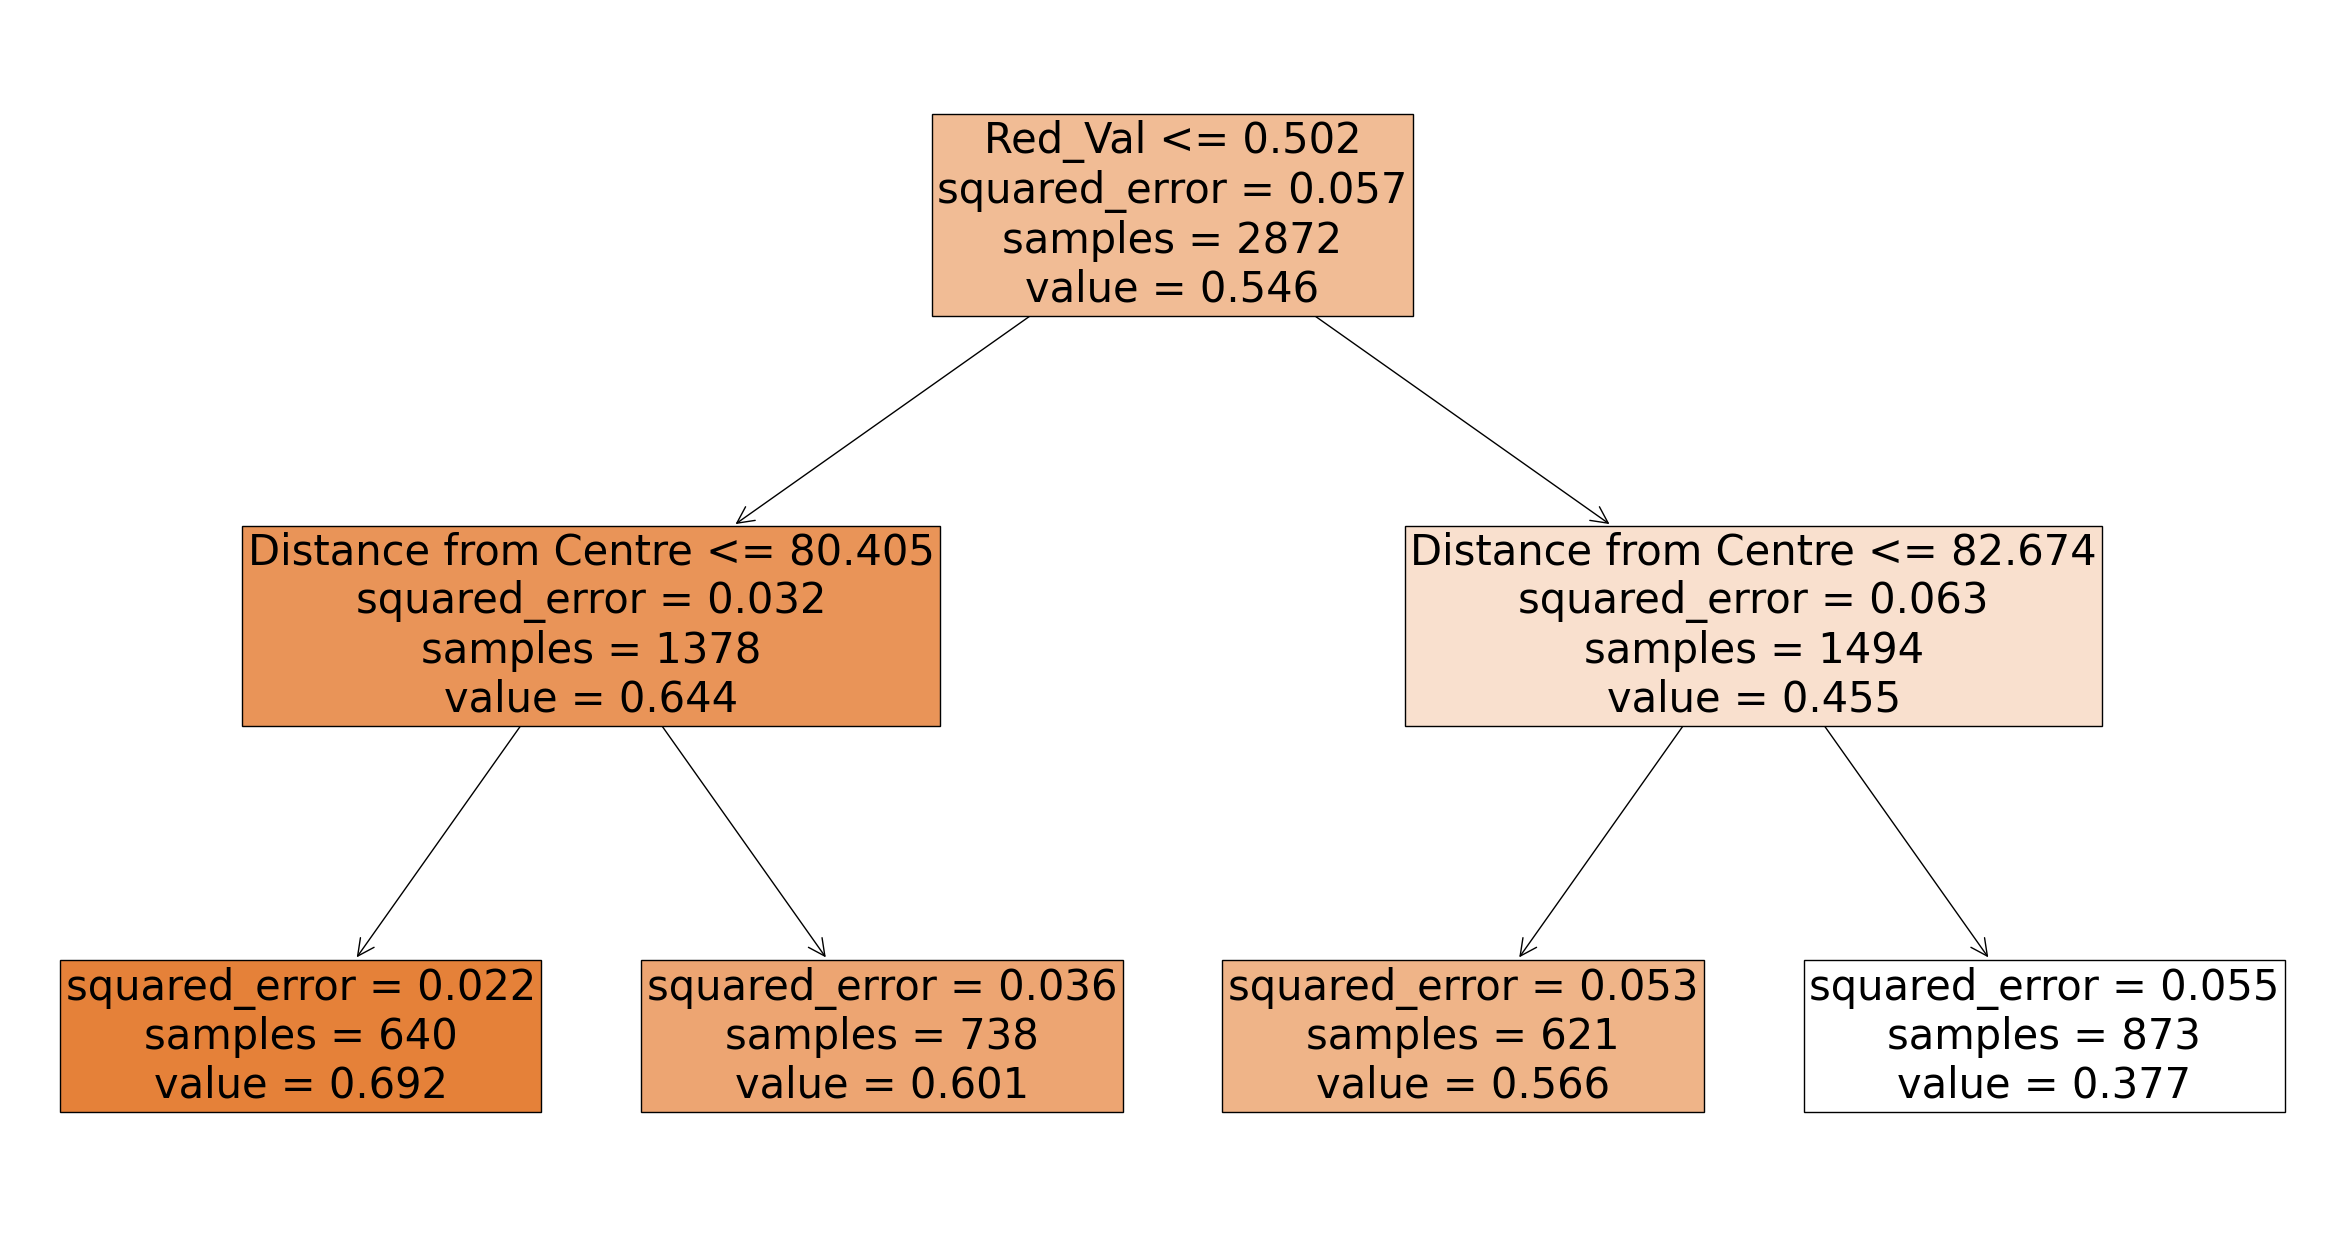

In [267]:
from sklearn.tree import plot_tree
regressor = DecisionTreeRegressor(max_depth=2)
regressor = regressor.fit(X_train, y_train)
plt.figure(figsize=(30,16))
plot_tree(regressor, max_depth=2, feature_names=['Red_Val', 'Distance from Centre'], filled=True, fontsize=30, precision=3)

plt.show()
